In [1]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
anger = pd.read_csv("dataset/AngerData.csv", delimiter="\t", encoding="utf-8")
fear = pd.read_csv("dataset/FearData.csv", delimiter="\t", encoding="utf-8")
joy = pd.read_csv("dataset/JoyData.csv", delimiter="\t", encoding="utf-8")
love = pd.read_csv("dataset/LoveData.csv", delimiter="\t", encoding="utf-8")
neutral = pd.read_csv("dataset/NeutralData.csv", delimiter="\t", encoding="utf-8")
sad = pd.read_csv("dataset/SadData.csv", delimiter="\t", encoding="utf-8")

In [3]:
print("Anger Dataset information")
anger.info()

print("Fear Dataset information")
fear.info()

print("Joy Dataset information")
joy.info()

print("Love Dataset information")
love.info()

print("Neutral Dataset information")
neutral.info()

print("Sad Dataset information")
sad.info()

Anger Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   1130 non-null   object
 1   Label   1130 non-null   object
dtypes: object(2)
memory usage: 17.8+ KB
Fear Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   911 non-null    object
 1   Label   911 non-null    object
dtypes: object(2)
memory usage: 14.4+ KB
Joy Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   1275 non-null   object
 1   Label   1275 non-null   object
dtypes: object(2)
memory usage: 20.0+ KB
Love Dataset information
<class 'pandas.core.frame.Dat

In [4]:
anger["Label"] = "Anger"
fear["Label"] = "Fear"
joy["Label"] = "Joy"
love["Label"] = "Love"
neutral["Label"] = "Neutral"
sad["Label"] = "Sad"

In [5]:
df = pd.concat([anger, fear, joy, love, neutral, sad], ignore_index=True)

In [6]:
print(df)

                                                  Tweet  Label
0                           pagi2 udah di buat emosi :)  Anger
1     kok stabilitas negara, memange 10 thn negara t...  Anger
2                          dah lah emosi mulu liat emyu  Anger
3     aib? bodoh benar! sebelum kata aib itu muncul,...  Anger
4                               dih lu yg nyebelin bego  Anger
...                                                 ...    ...
7075  pagi saat seisi semesta sujud pada zat yg acap...    Sad
7076  meski engkau yg pergi, meski engkau yg meningg...    Sad
7077                     udah biasa kalah dan tersakiti    Sad
7078  apakabar ku?. apakah baik-baik saja,, tidak, a...    Sad
7079      this user sdg tidak.baik.baik saja sdg stress    Sad

[7080 rows x 2 columns]


In [7]:
print(df['Label'].value_counts())

Neutral    2001
Joy        1275
Anger      1130
Sad        1003
Fear        911
Love        760
Name: Label, dtype: int64


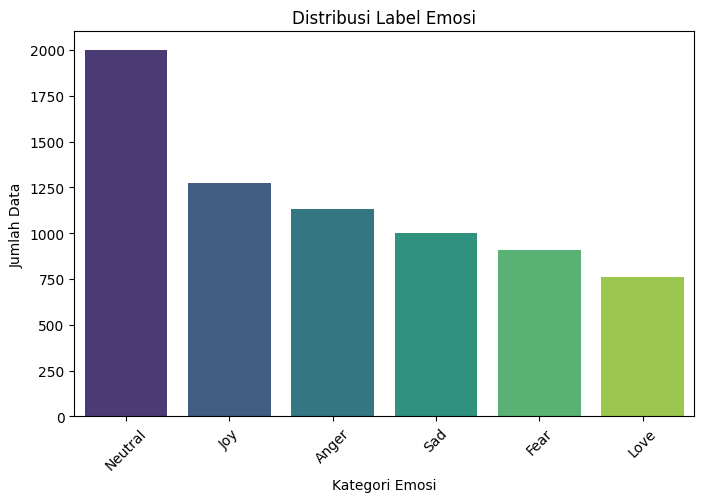

In [8]:
# Visualisasi distribusi label
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Label", order=df["Label"].value_counts().index, palette="viridis")
plt.title("Distribusi Label Emosi")
plt.xlabel("Kategori Emosi")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.show()

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7080 non-null   object
 1   Label   7080 non-null   object
dtypes: object(2)
memory usage: 110.8+ KB
None


In [10]:
# Cek jumlah data kosong
print("Jumlah data kosong:\n", df.isnull().sum())
# Hapus data yang kosong jika ada
df = df.dropna()

Jumlah data kosong:
 Tweet    0
Label    0
dtype: int64


In [11]:
# Cek data duplikat
print("Jumlah data duplikat:", df.duplicated().sum())

# Hapus duplikat jika ada
df = df.drop_duplicates()

Jumlah data duplikat: 52


In [12]:
print(df['Label'].value_counts())

Neutral    1992
Joy        1258
Anger      1123
Sad         995
Fear        906
Love        754
Name: Label, dtype: int64


# PREPROCESSING

In [13]:
import re
import string
import emoji  # Harus install dulu: pip install emoji
from wordcloud import STOPWORDS  # Bisa ditambah manual nanti

In [14]:
# Kamus singkatan/slang
slang_dict = {
    "anjg": "anjing",
    "gpp": "gak apa apa",
    "rs": "rumah sakit",
    "kmrn": "kemarin",
    "tdk": "tidak",
    "yg": "yang",
    "org": "orang",
    "sbg": "sebagai",
    "gw": "gua",
    "gt": "gitu",
    "gk": "gak",
    "lgsg": "langsung",
    "cr": "cari",
    "dr": "dari",
    "dri": "dari",
    "dl": "dulu",
    "dh": "dah",
    "dlm": "dalam",
    "dmn": "dimana",
    "dpt": "dapet",
    "hrs": "harus",
    "blm": "belum",
    "bnr": "benar",
    "bgt": "banget",
    "sbnrnya": "sebenarnya",
    "sy": "saya",
    "sm": "sama",
    "sdh": "sudah",
    "sdg": "sedang",
    "skrg": "sekarang",
    "udh": "udah",
    "utk": "untuk",
    "mls": "malas",
    "nmbh": "nambah",
    "met": "selamat",
    "emg": "emang",
    "jg": "juga",
    "jgn": "jangan",
    "td": "tadi",
    "km": "kamu",
    "ksl": "kesal",
    "krn": "karena",
    "krna": "karena",
    "klo": "kalo",
    "knp": "kenapa",
    "kga": "kaga",
    "kyk": "kayak",
    "kk": "kakak",
    "krg": "kurang",
    "pd": "pada",
    "pke": "pakai",
    "pg": "pagi",
    "nnti": "nanti",
    "lg": "lagi",
    "lgi": "lagi",
    "lps": "lepas",
    "tpi": "tapi",
    "thn": "tahun",
    "trs": "terus",
    "ttp": "tetap",
    "tmpt": "tempat",
    "tp": "tapi"
}

In [15]:
# Normalisasi teks
def normalize_text(text):
    words = text.split()
    words = [slang_dict[word] if word in slang_dict else word for word in words]
    return " ".join(words)

In [16]:
# Fungsi pembersihan teks
def clean_text(text):
    text = text.lower()  # Ubah ke huruf kecil
    text = emoji.replace_emoji(text, replace="")  # Hapus emoji
    text = re.sub(r"http\S+|www\S+|@\w+|#", "", text)  # Hapus URL, mention, hashtag
    text = text.translate(str.maketrans("", "", string.punctuation))  # Hapus tanda baca
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = normalize_text(text)  # Ganti slang jadi kata standar
    text = text.strip()
    return text

In [17]:
df["clean_text"] = df["Tweet"].apply(clean_text)

In [18]:
# Contoh sebelum & sesudah
print(df[["Tweet", "clean_text"]].head(10))

                                               Tweet  \
0                        pagi2 udah di buat emosi :)   
1  kok stabilitas negara, memange 10 thn negara t...   
2                       dah lah emosi mulu liat emyu   
3  aib? bodoh benar! sebelum kata aib itu muncul,...   
4                            dih lu yg nyebelin bego   
5  asli malu maluin org indo tolol yg rep latah "...   
6                                    drama abg tolol   
7  masih emosi sih sama katla kemarin. mana keter...   
8  bangsat tribute no.1, bencana no.2 mau ngalahi...   
9  pengen pergi jauh terus teriak sambil nangis s...   

                                          clean_text  
0                            pagi udah di buat emosi  
1  kok stabilitas negara memange tahun negara tid...  
2                       dah lah emosi mulu liat emyu  
3  aib bodoh benar sebelum kata aib itu muncul te...  
4                          dih lu yang nyebelin bego  
5  asli malu maluin orang indo tolol yang rep lat... 

# ANALIS

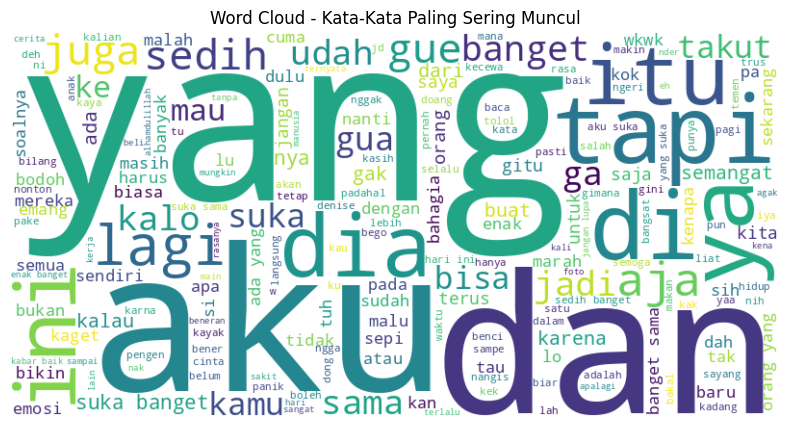

In [19]:
from wordcloud import WordCloud

# Gabungkan semua teks jadi satu
text = " ".join(df["clean_text"])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Tampilkan
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Kata-Kata Paling Sering Muncul")
plt.show()

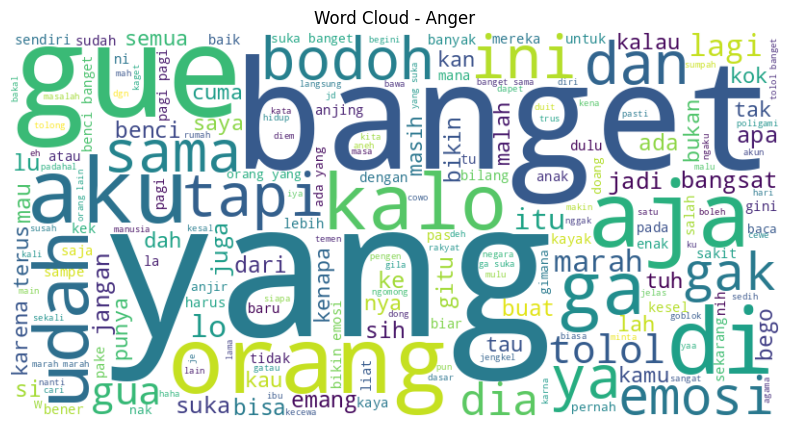

In [20]:
def plot_wordcloud(label):
    text = " ".join(df[df["Label"] == label]["clean_text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {label}")
    plt.show()

# Contoh: Word Cloud untuk kategori 'Anger'
plot_wordcloud("Anger")

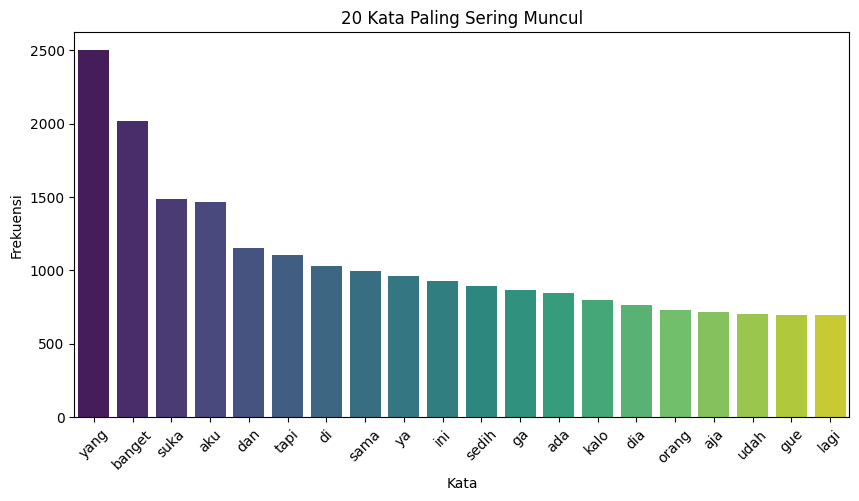

In [21]:
from collections import Counter

# Hitung kata yang paling sering muncul
word_freq = Counter(" ".join(df["clean_text"]).split())

# Ambil 20 kata paling sering muncul
common_words = word_freq.most_common(20)

# Visualisasi
plt.figure(figsize=(10,5))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words], palette="viridis")
plt.xticks(rotation=45)
plt.title("20 Kata Paling Sering Muncul")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.show()

# BASELINE MODEL

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [23]:
# Pisahkan data train & test (80:20)
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["Label"], test_size=0.2, random_state=42, stratify=df["Label"])

In [24]:
# Tampilkan jumlah data
print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 5622
Jumlah data test: 1406


In [25]:
# TF-IDF vektor
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  # Bisa coba unigram/bigram
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [26]:
# Cek bentuk data setelah TF-IDF
print("Shape TF-IDF Train:", X_train_tfidf.shape)
print("Shape TF-IDF Test:", X_test_tfidf.shape)

Shape TF-IDF Train: (5622, 5000)
Shape TF-IDF Test: (1406, 5000)


In [27]:
# Inisialisasi model dengan class weighting
model = LogisticRegression(class_weight="balanced", max_iter=500)

In [28]:
# Train model
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

In [29]:
# Prediksi di data test
y_pred = model.predict(X_test_tfidf)

In [30]:
# Print akurasi
print("Akurasi:", accuracy_score(y_test, y_pred))

# Lihat laporan klasifikasi
print(classification_report(y_test, y_pred))

Akurasi: 0.7268847795163584
              precision    recall  f1-score   support

       Anger       0.74      0.75      0.75       225
        Fear       0.79      0.82      0.81       181
         Joy       0.77      0.69      0.72       252
        Love       0.60      0.91      0.72       151
     Neutral       0.75      0.62      0.68       398
         Sad       0.72      0.74      0.73       199

    accuracy                           0.73      1406
   macro avg       0.73      0.76      0.73      1406
weighted avg       0.74      0.73      0.73      1406

